<a href="https://colab.research.google.com/github/BatoolMM/fastai/blob/master/Chapter_4_Under_the_Hood_Training_a_Digit_Classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 4. Under the Hood: Training a Digit Classifier**

In [ ]:
!pip install -Uqq fastbook
!pip install fastcore
!pip install fastai
!pip install utils

In [ ]:
from utils import *
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

In [ ]:
?download_images

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

In [ ]:
(path/'train'/'7').ls()

(#6265) [Path('/root/.fastai/data/mnist_sample/train/7/31219.png'),Path('/root/.fastai/data/mnist_sample/train/7/23173.png'),Path('/root/.fastai/data/mnist_sample/train/7/6623.png'),Path('/root/.fastai/data/mnist_sample/train/7/2297.png'),Path('/root/.fastai/data/mnist_sample/train/7/5897.png'),Path('/root/.fastai/data/mnist_sample/train/7/51819.png'),Path('/root/.fastai/data/mnist_sample/train/7/30759.png'),Path('/root/.fastai/data/mnist_sample/train/7/13691.png'),Path('/root/.fastai/data/mnist_sample/train/7/6587.png'),Path('/root/.fastai/data/mnist_sample/train/7/10474.png')...]

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [ ]:
tensor_threes = [tensor(Image.open(i)) for i in threes]
tensor_sevens = [tensor(Image.open(i)) for i in sevens]
tensor_threes[1][4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

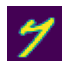

In [ ]:
show_image(tensor_sevens[1])

In [ ]:
stacked_threes = torch.stack(tensor_threes).float()/255
stacked_sevens = torch.stack(tensor_sevens).float()/255

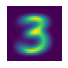

In [ ]:
show_image(stacked_threes.mean(0))

In [ ]:
abs_three_tomeanthree = (stacked_threes.mean(0) - stacked_threes[1]).abs().mean()
rmse_three_tomeanthree = ((stacked_threes.mean(0) - stacked_threes[1])**2).mean().sqrt()
abs_three_tomeanthree, rmse_three_tomeanthree

(tensor(0.1114), tensor(0.2021))

In [ ]:
abs_three_tomeanseven = (stacked_sevens.mean(0) - stacked_threes[1]).abs().mean()
rmse_three_tomeanseven = ((stacked_sevens.mean(0) - stacked_threes[1])**2).mean().sqrt()
abs_three_tomeanseven, rmse_three_tomeanseven

(tensor(0.1586), tensor(0.3021))

In [ ]:
#in pytorch

abs_three_tomeanseven = F.l1_loss(stacked_sevens.mean(0), stacked_threes[1])
rmse_three_tomeanseven = F.mse_loss(stacked_sevens.mean(0) , stacked_threes[1]).sqrt()
abs_three_tomeanseven, rmse_three_tomeanseven

(tensor(0.1586), tensor(0.3021))

## **Validation set**

In [ ]:
(path/'valid').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/valid/7'),Path('/root/.fastai/data/mnist_sample/valid/3')]

In [ ]:
valid_three = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'3').ls()])
valid_three = valid_three.float()/255
valid_seven = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'7').ls()])
valid_seven = valid_seven.float()/225
valid_three.shape,valid_seven.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [ ]:
mean_seven = stacked_sevens.mean(0)
mean_three = stacked_threes.mean(0)
#without broadcasting
(valid_seven - mean_three).abs().mean(), (valid_seven - mean_three).abs().mean().shape

#with broadcasting
(valid_seven - mean_three).abs().mean((-1,-2)), (valid_seven - mean_three).abs().mean((-1,-2)).shape

(tensor([0.1574, 0.1652, 0.1653,  ..., 0.1569, 0.1814, 0.1599]),
 torch.Size([1028]))

In [ ]:
def mnist_l1_loss(a, b):
  return (a - b).abs().mean((-1, -2))

mnist_l1_loss(valid_seven, mean_three,), mnist_l1_loss(valid_seven, mean_three).shape

(tensor([0.1574, 0.1652, 0.1653,  ..., 0.1569, 0.1814, 0.1599]),
 torch.Size([1028]))

In [ ]:
def is_three(x):
  mean_seven = stacked_sevens.mean(0)
  mean_three = stacked_threes.mean(0)
  return mnist_l1_loss(x, mean_three) < mnist_l1_loss(x, mean_seven)

is_three(valid_three), is_three(valid_three).float()

(tensor([False,  True,  True,  ..., False,  True,  True]),
 tensor([0., 1., 1.,  ..., 0., 1., 1.]))

In [ ]:
accuracy_3 = is_three(valid_three).float().mean()
accuracy_7 = (1 - is_three(valid_seven).float()).mean()
accuracy_3, accuracy_7

(tensor(0.9168), tensor(0.9864))

## **Gradient descent**

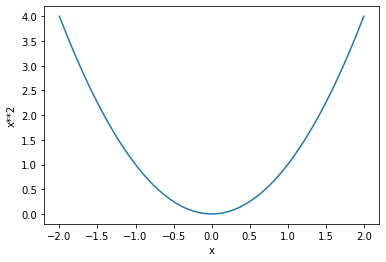

In [ ]:
def f(x):
  return x**2

def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

plot_function(f,'x', 'x**2')

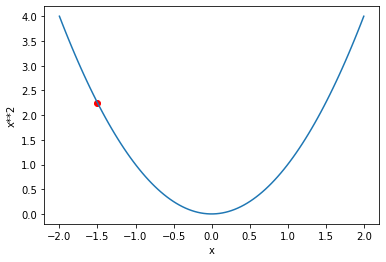

In [ ]:
plot_function(f,'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [ ]:
def f(x):
  return x**2

In [ ]:
der_x_3 = tensor(3.).requires_grad_()
der_x_3

tensor(3., requires_grad=True)

In [ ]:
der_f = f(der_x_3)
der_f

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
der_f.backward()
der_x_3.grad

tensor(6.)

## **Roller coaster**

In [ ]:
time = torch.arange(20.)
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [ ]:
#original speed
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
speed

tensor([67.6628, 50.9495, 42.4726, 34.3216, 22.3349, 16.4956, 10.6454,  7.7215,
         4.9476, -0.6292,  5.1052, -0.7205,  8.8464, 11.6502, 17.1770, 20.4474,
        31.2583, 44.6699, 57.1893, 71.6422])

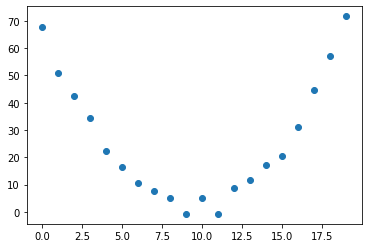

In [ ]:
plt.scatter(time, speed)

In [ ]:
#the equation
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [ ]:
#initi the weights
params = torch.randn(3).requires_grad_()
params

tensor([0.6969, 0.5745, 0.2319], requires_grad=True)

In [ ]:
#define loss function
def mse(preds, targets):
  return ((targets - preds)**2).mean()

In [ ]:
#check the weights with function and lose function
preds = f(time, params)
preds

tensor([2.3195e-01, 1.5034e+00, 4.1686e+00, 8.2276e+00, 1.3680e+01, 2.0527e+01,
        2.8767e+01, 3.8402e+01, 4.9430e+01, 6.1851e+01, 7.5667e+01, 9.0876e+01,
        1.0748e+02, 1.2548e+02, 1.4487e+02, 1.6565e+02, 1.8783e+02, 2.1140e+02,
        2.3637e+02, 2.6273e+02], grad_fn=<AddBackward0>)

In [ ]:
loss = mse(preds, speed)
loss 

tensor(10537.9785, grad_fn=<MeanBackward0>)

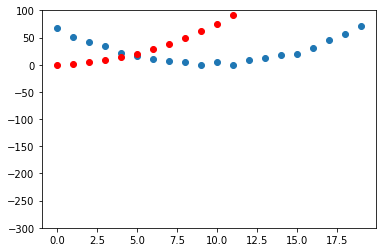

In [ ]:
def show_pred(preds, plot=None):
  if plot is None:
    plot = plt.subplots()[1]
    plot.scatter(time, speed)
    plot.scatter(time, to_np(preds), color ='red')
    plot.set_ylim(-300, 100)

show_pred(preds)

In [ ]:
loss.backward()
params.grad

tensor([33416.9844,  2156.0581,   131.0948])

In [ ]:
 lr = 1e-5
params.data -= lr *params.grad.data
params.grad = None

In [ ]:
preds = f(time, params)
mse(preds, speed)

tensor(2492.1802, grad_fn=<MeanBackward0>)

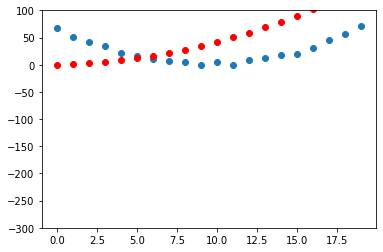

In [ ]:
show_pred(preds)

In [ ]:
params

tensor([0.3627, 0.5530, 0.2306], requires_grad=True)

In [ ]:
params.data

tensor([0.3627, 0.5530, 0.2306])

In [ ]:
def apply_steps(params, prt=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  lr = 1e-5
  params.data -= lr * params.grad.data
  params.grad = None
  if prt:
    print(loss.item())
  return preds

In [ ]:
for i in range(10):
  apply_steps(params)

969.666015625
681.5570068359375
627.03466796875
616.7144775390625
614.7584228515625
614.3851318359375
614.3116455078125
614.2945556640625
614.2882080078125
614.2839965820312


## **The MNIST Loss Function**

In [ ]:
# make the training into vector
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape, stacked_threes.shape, stacked_sevens.shape

(torch.Size([12396, 784]),
 torch.Size([6131, 28, 28]),
 torch.Size([6265, 28, 28]))

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [ ]:
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [ ]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [ ]:
valid_x = torch.cat([valid_three, valid_seven]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_three) + [0]*len(valid_seven)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [ ]:
def init(size, sd=1):
  return (torch.randn(size)*sd).requires_grad_()

In [ ]:
weights = init((28*28, 1))
bias = init(1)
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

In [ ]:
pred = (train_x[0]*weights.T).sum() + bias
pred

tensor([9.2459], grad_fn=<AddBackward0>)

In [ ]:
def pred(train_x):
  return train_x @ weights + bias

pred = pred(train_x)

In [ ]:
pred.shape

torch.Size([12396, 1])

In [ ]:
pred

tensor([[ 9.2459],
        [14.3221],
        [10.3733],
        ...,
        [-1.6361],
        [13.4566],
        [-3.6190]], grad_fn=<AddBackward0>)

In [ ]:
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [ ]:
pred[1]

tensor([14.3221], grad_fn=<SelectBackward>)

In [ ]:
train_y[1]

tensor([1])

In [ ]:
correct_3 = (pred>0).float() == train_y
correct_3

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [ True]])

In [ ]:
correct_7 = (pred<0).float() == train_y
correct_7

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [ True],
        [False]])

In [ ]:
correct_3.float().mean().item()

0.6886898875236511

In [ ]:
correct_7.float().mean().item()

0.3113101124763489